In [71]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import ne_chunk, pos_tag
from nltk.tree import Tree
import spacy
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from matplotlib import pyplot as plt
%matplotlib inline
from textblob import Word
from textblob import TextBlob
import gensim
from gensim.models.phrases import Phrases, Phraser
from gensim.models import KeyedVectors
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
globe_input_file = r"C:\Users\dukec\My-ML-Workspace\globe_6B\glove.6B.50d.txt"
globe_output_file = r"C:\Users\dukec\My-ML-Workspace\Omdena Local Chapters\liberia-fake-news-detection\src\tasks\task-2-exploratory-data-analysis\word2vec.txt"

In [28]:
df = pd.read_excel(r'C:\Users\dukec\My-ML-Workspace\Omdena Local Chapters\liberia-fake-news-detection\src\data\dubawa_label_data.xlsx')

In [29]:
df.head()

,TITLE,publisher_name,content,publication_date,link,Label
0,Misleading! McGill and Cllr. Cephus was not sa...,Dubawa,Claim:A senior strategist on the Campaign Team...,2023-01-08 00:00:00,https://dubawa.org/misleading-mcgill-and-cllr-...,0
1,Weah’s CDC fails to uphold 40% quota promise f...,Dubawa,President George Weah's three-party-led govern...,31/07/2023,https://dubawa.org/weahs-cdc-fails-to-uphold-4...,1
2,Former Vice President did not accuse President...,Dubawa,Claim: Vice chairman of Liberia Anti Corruptio...,23/07/2023,https://dubawa.org/former-vice-president-did-n...,0
3,Misleading! Liberia does not have world’s high...,Dubawa,Claim: The presidential hopeful and political ...,20/07/2023,https://dubawa.org/misleading-liberia-does-not...,0
4,False! All Liberian Party not fielding preside...,Dubawa,Claim: A viral flier on social media (Facebook...,2023-06-07 00:00:00,https://dubawa.org/false-all-liberian-party-no...,0


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   TITLE             73 non-null     object
 1   publisher_name    73 non-null     object
 2   content           73 non-null     object
 3   publication_date  73 non-null     object
 4   link              73 non-null     object
 5   Label             73 non-null     int64 
dtypes: int64(1), object(5)
memory usage: 3.5+ KB


# Text pre-processing and visualizations

Converting all statements to lower case. This reduces redundancy and normalize words with upper case letters in between. I'm storing the formatted text in another column because I'll need the original text to identify entities, which will be lost if converted to lower case.

In [31]:
df['content_lower'] = df['content'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df.head()

,TITLE,publisher_name,content,publication_date,link,Label,content_lower
0,Misleading! McGill and Cllr. Cephus was not sa...,Dubawa,Claim:A senior strategist on the Campaign Team...,2023-01-08 00:00:00,https://dubawa.org/misleading-mcgill-and-cllr-...,0,claim:a senior strategist on the campaign team...
1,Weah’s CDC fails to uphold 40% quota promise f...,Dubawa,President George Weah's three-party-led govern...,31/07/2023,https://dubawa.org/weahs-cdc-fails-to-uphold-4...,1,president george weah's three-party-led govern...
2,Former Vice President did not accuse President...,Dubawa,Claim: Vice chairman of Liberia Anti Corruptio...,23/07/2023,https://dubawa.org/former-vice-president-did-n...,0,claim: vice chairman of liberia anti corruptio...
3,Misleading! Liberia does not have world’s high...,Dubawa,Claim: The presidential hopeful and political ...,20/07/2023,https://dubawa.org/misleading-liberia-does-not...,0,claim: the presidential hopeful and political ...
4,False! All Liberian Party not fielding preside...,Dubawa,Claim: A viral flier on social media (Facebook...,2023-06-07 00:00:00,https://dubawa.org/false-all-liberian-party-no...,0,claim: a viral flier on social media (facebook...


# WordcLoud With Unigrams

Generating unigram wordcloud to see important words in the text.

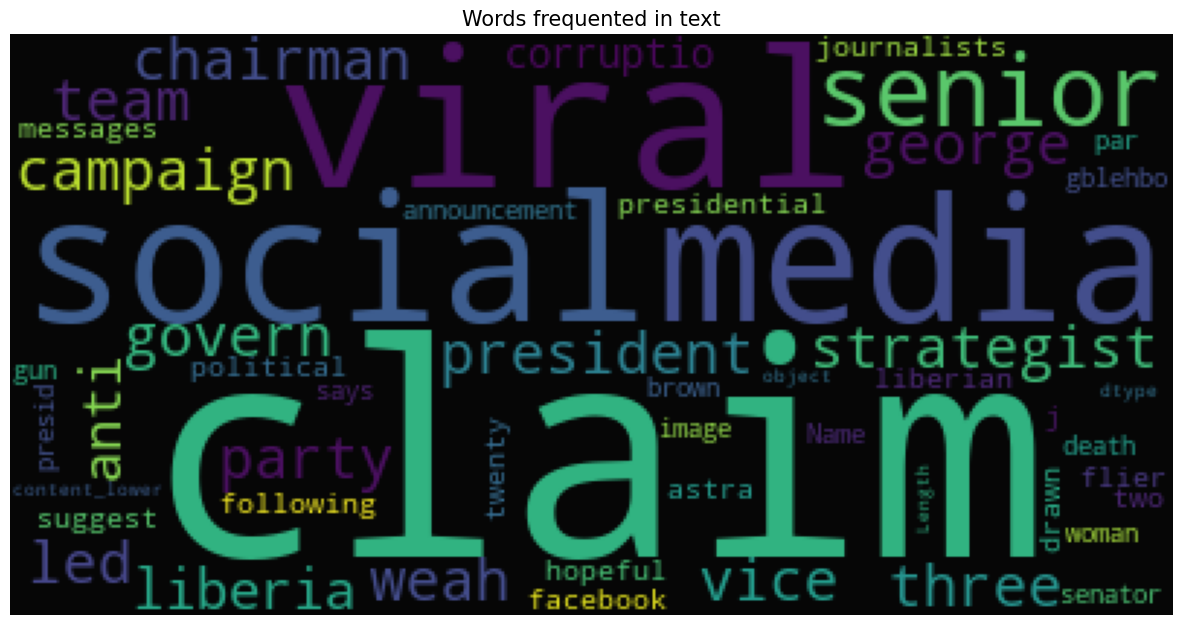

In [32]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                        background_color='black',
                        stopwords=stopwords,
                        max_words=200, 
                        random_state=42).generate(str(df['content_lower']))

plt.figure(figsize=(15,10))
plt.axis("off")
plt.title("Words frequented in text", fontsize=15)
plt.imshow(wordcloud.recolor(colormap= 'viridis' , random_state=42), alpha=0.98)
plt.show()

Stopwords like "a", "the" etc are not useful while working with text, in general. The better way is to have a custom stopwords list relevant to the use case because words like "of" can be present in company name and we don't want that to be removed. For the purpose of this problem and time constraint I'm going with the general list.

In [33]:
df['content'] = df['content'].apply(lambda x: " ".join(x for x in x.split() if x not in stopwords))
df['content_lower'] = df['content_lower'].apply(lambda x: " ".join(x for x in x.split() if x not in stopwords))
df.head()

,TITLE,publisher_name,content,publication_date,link,Label,content_lower
0,Misleading! McGill and Cllr. Cephus was not sa...,Dubawa,Claim:A senior strategist Campaign Team Collab...,2023-01-08 00:00:00,https://dubawa.org/misleading-mcgill-and-cllr-...,0,claim:a senior strategist campaign team collab...
1,Weah’s CDC fails to uphold 40% quota promise f...,Dubawa,President George Weah's three-party-led govern...,31/07/2023,https://dubawa.org/weahs-cdc-fails-to-uphold-4...,1,president george weah's three-party-led govern...
2,Former Vice President did not accuse President...,Dubawa,Claim: Vice chairman Liberia Anti Corruption C...,23/07/2023,https://dubawa.org/former-vice-president-did-n...,0,claim: vice chairman liberia anti corruption c...
3,Misleading! Liberia does not have world’s high...,Dubawa,Claim: The presidential hopeful political lead...,20/07/2023,https://dubawa.org/misleading-liberia-does-not...,0,claim: presidential hopeful political leader m...
4,False! All Liberian Party not fielding preside...,Dubawa,"Claim: A viral flier social media (Facebook, W...",2023-06-07 00:00:00,https://dubawa.org/false-all-liberian-party-no...,0,"claim: viral flier social media (facebook, wha..."


Putting "(" and ")" in place of its POS tag. This step is not necessary but as I have to work with words in general for finding similarities and closest matches, I need these as punctuations. 

In [34]:
df['content_lower'] = df['content_lower'].apply(lambda x: x.replace("-lrb-", "("))
df['content_lower'] = df['content_lower'].apply(lambda x: x.replace("-rrb-", ")"))
df['content'] = df['content'].apply(lambda x: x.replace("-LRB-", "("))
df['content'] = df['content'].apply(lambda x: x.replace("-RRB-", ")"))
df.head()

,TITLE,publisher_name,content,publication_date,link,Label,content_lower
0,Misleading! McGill and Cllr. Cephus was not sa...,Dubawa,Claim:A senior strategist Campaign Team Collab...,2023-01-08 00:00:00,https://dubawa.org/misleading-mcgill-and-cllr-...,0,claim:a senior strategist campaign team collab...
1,Weah’s CDC fails to uphold 40% quota promise f...,Dubawa,President George Weah's three-party-led govern...,31/07/2023,https://dubawa.org/weahs-cdc-fails-to-uphold-4...,1,president george weah's three-party-led govern...
2,Former Vice President did not accuse President...,Dubawa,Claim: Vice chairman Liberia Anti Corruption C...,23/07/2023,https://dubawa.org/former-vice-president-did-n...,0,claim: vice chairman liberia anti corruption c...
3,Misleading! Liberia does not have world’s high...,Dubawa,Claim: The presidential hopeful political lead...,20/07/2023,https://dubawa.org/misleading-liberia-does-not...,0,claim: presidential hopeful political leader m...
4,False! All Liberian Party not fielding preside...,Dubawa,"Claim: A viral flier social media (Facebook, W...",2023-06-07 00:00:00,https://dubawa.org/false-all-liberian-party-no...,0,"claim: viral flier social media (facebook, wha..."


I tried using Lemmatization but it was reducing some words to incorrect base form beacuse the lemmatizer has no knowledge of the dataset, so I'm skipping it. Lemmatization and Stemming should be used carefully as they can destroy important words.

In [35]:
# df['text'] = df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
# df['text'].head()

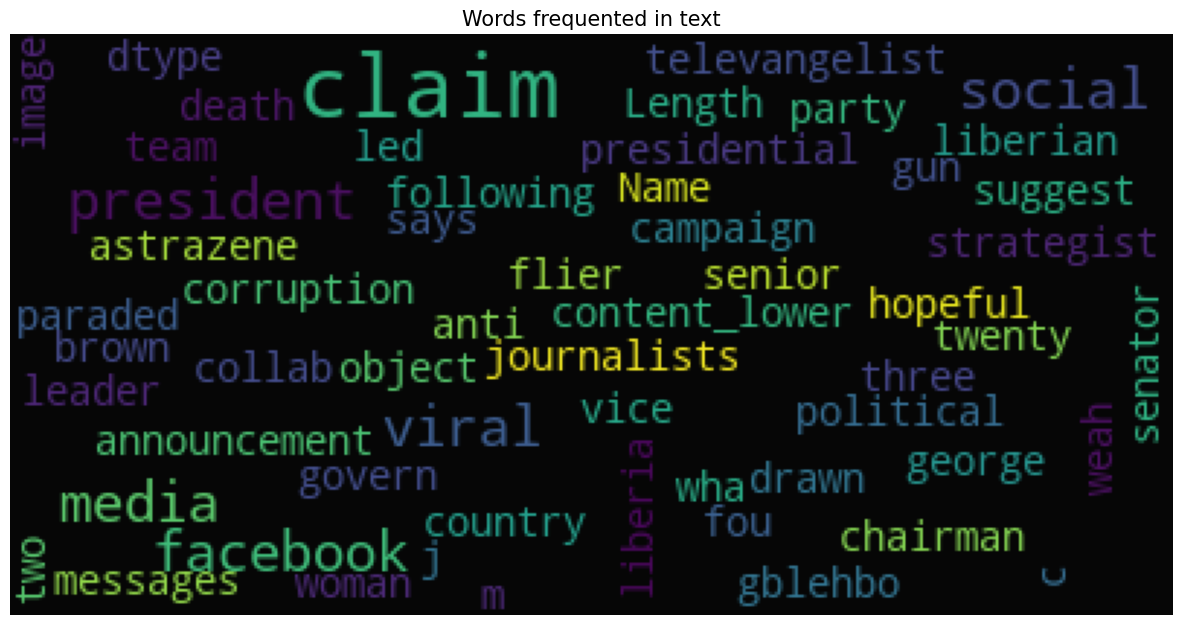

In [36]:
wordcloud = WordCloud(
                        background_color='black',
                        stopwords=stopwords,
                        max_words=200,
                        max_font_size=30,
                        random_state=42).generate(str(df['content_lower']))

plt.figure(figsize=(15,10))
plt.axis("off")
plt.title("Words frequented in text", fontsize=15)
plt.imshow(wordcloud.recolor(colormap= 'viridis' , random_state=42), alpha=0.98)
plt.show()

Wordcloud with some cleaned text. We can see that it is somewhat better than the previous one as it brings down the importance of some words like **segmentation**, **many** etc., which are not important to this text.

## Wordcloud with Trigrams and Bigrams

Looking at the text, its relevance is to **Natural Language Processing**. This word is not covered in unigrams so we to have trigrams and bigrams which will give much more information about the corpus.

Using **Gensim's Phrases** we can generate bigrams and trigrams.

In [37]:
sentences=[text.split() for text in df.content_lower.values]
phrases = Phrases(sentences)
bigram = Phraser(phrases)
trigram = Phrases(bigram[sentences])

In [38]:
df['trigrams'] = df['content_lower'].apply(lambda x: " ".join(trigram[bigram[x.split()]]))
df.head()

,TITLE,publisher_name,content,publication_date,link,Label,content_lower,trigrams
0,Misleading! McGill and Cllr. Cephus was not sa...,Dubawa,Claim:A senior strategist Campaign Team Collab...,2023-01-08 00:00:00,https://dubawa.org/misleading-mcgill-and-cllr-...,0,claim:a senior strategist campaign team collab...,claim:a senior strategist campaign team collab...
1,Weah’s CDC fails to uphold 40% quota promise f...,Dubawa,President George Weah's three-party-led govern...,31/07/2023,https://dubawa.org/weahs-cdc-fails-to-uphold-4...,1,president george weah's three-party-led govern...,president_george weah's three-party-led govern...
2,Former Vice President did not accuse President...,Dubawa,Claim: Vice chairman Liberia Anti Corruption C...,23/07/2023,https://dubawa.org/former-vice-president-did-n...,0,claim: vice chairman liberia anti corruption c...,claim: vice chairman liberia anti corruption c...
3,Misleading! Liberia does not have world’s high...,Dubawa,Claim: The presidential hopeful political lead...,20/07/2023,https://dubawa.org/misleading-liberia-does-not...,0,claim: presidential hopeful political leader m...,claim: presidential hopeful political_leader m...
4,False! All Liberian Party not fielding preside...,Dubawa,"Claim: A viral flier social media (Facebook, W...",2023-06-07 00:00:00,https://dubawa.org/false-all-liberian-party-no...,0,"claim: viral flier social media (facebook, wha...","claim: viral flier social_media (facebook, wha..."


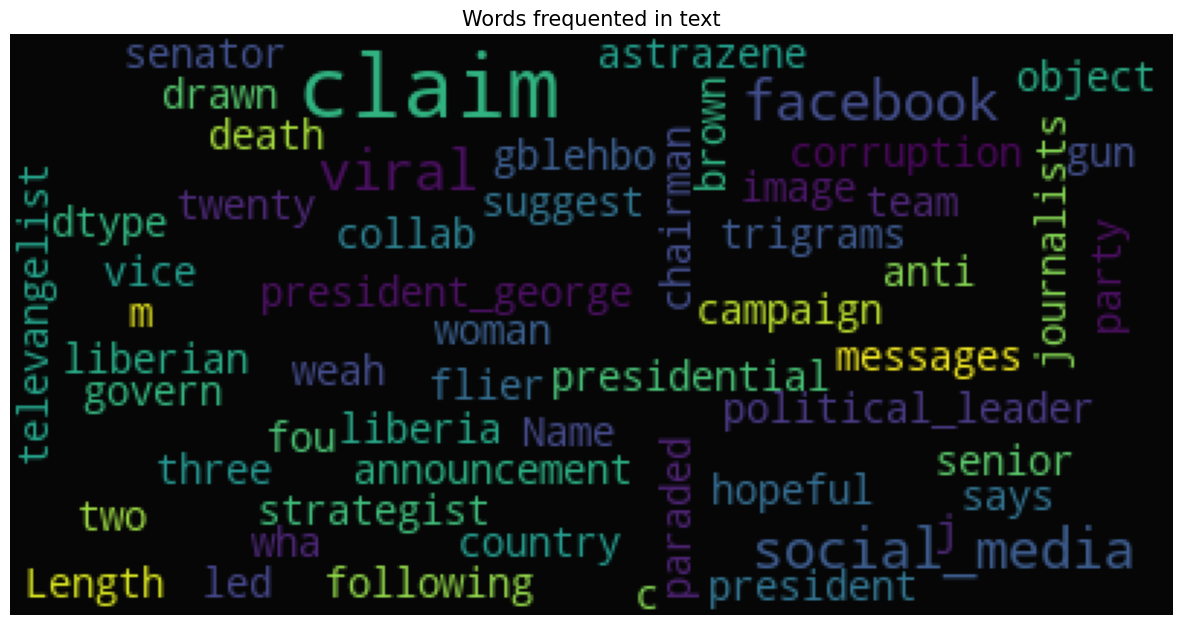

In [39]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                        background_color='black',
                        stopwords=stopwords,
                        max_words=200,
                        max_font_size=30,
                        random_state=42).generate(str(df['trigrams']))

plt.figure(figsize=(15,10))
plt.axis("off")
plt.title("Words frequented in text", fontsize=15)
plt.imshow(wordcloud.recolor(colormap= 'viridis' , random_state=42), alpha=0.98)
plt.show()

This is a much better wordcloud which clearly shows what this corpus is talking about. **nlp** is more highlighted now. Words like **natural_language_processing** and **text_segmentation** are visible now which were not there in previuos cases.

# Finding entities in text

I'm using **spacy** to get the enitities present in the text. I'm using **en_core_web_sm** model of spacy which is pre-trained in general english dictionary. As this is a demo work, this step should work but in real product development cases this step should not be done. The model should be trained according to the business need so that it can map the correct entities. Like in this case, the model is mappling **NLP** to **ORG** label because that's what it is trained like, all caps words should be organization names.

It also fails to recognize **Natural language processing** as an entity because it has not be trained to do so.

In [40]:
def get_entities(text):
    parsed_text = nlp(text)
    entities = list(parsed_text.ents)
    named_entities = []
    for entity in entities:
        if entity.label_ in ["ORG", "PERSON"]:
            named_entities.append(entity)
    return named_entities

In [43]:
nlp=spacy.load('en_core_web_lg')

In [44]:
df['entities'] = df['content'].apply(get_entities)

In [45]:
df.head()

,TITLE,publisher_name,content,publication_date,link,Label,content_lower,trigrams,entities
0,Misleading! McGill and Cllr. Cephus was not sa...,Dubawa,Claim:A senior strategist Campaign Team Collab...,2023-01-08 00:00:00,https://dubawa.org/misleading-mcgill-and-cllr-...,0,claim:a senior strategist campaign team collab...,claim:a senior strategist campaign team collab...,"[(Campaign, Team, Collaborating, Political, Pa..."
1,Weah’s CDC fails to uphold 40% quota promise f...,Dubawa,President George Weah's three-party-led govern...,31/07/2023,https://dubawa.org/weahs-cdc-fails-to-uphold-4...,1,president george weah's three-party-led govern...,president_george weah's three-party-led govern...,"[(George, Weah), (CDC), (Weah), (benchmark?DUB..."
2,Former Vice President did not accuse President...,Dubawa,Claim: Vice chairman Liberia Anti Corruption C...,23/07/2023,https://dubawa.org/former-vice-president-did-n...,0,claim: vice chairman liberia anti corruption c...,claim: vice chairman liberia anti corruption c...,"[(Liberia, Anti, Corruption, Commission), (Kan..."
3,Misleading! Liberia does not have world’s high...,Dubawa,Claim: The presidential hopeful political lead...,20/07/2023,https://dubawa.org/misleading-liberia-does-not...,0,claim: presidential hopeful political leader m...,claim: presidential hopeful political_leader m...,"[(Movement, Progressive, Change), (MPC), (Sime..."
4,False! All Liberian Party not fielding preside...,Dubawa,"Claim: A viral flier social media (Facebook, W...",2023-06-07 00:00:00,https://dubawa.org/false-all-liberian-party-no...,0,"claim: viral flier social media (facebook, wha...","claim: viral flier social_media (facebook, wha...","[(Facebook), (Henry, P, Costa, River, -, Gee, ..."


In [46]:
unique_entities = set()
for entry in df.entities.values:
    for entity in entry:
        if entity:
            if (len(entity.orth_.strip()) == 3 and entity.orth_.strip().isupper()) or len(entity.orth_.strip()) > 3:
                unique_entities.add(entity.orth_.strip())

unique_entities

{'Theodore Momo',
 'CCTV',
 'Liberia Executive mansion',
 "The Daily Observer's",
 'Ellen Johnson Sirleaf OP',
 'Kpui',
 'LiberiaSince',
 'SIM',
 'Global Tracking Maritime Services',
 '38%.Verdict',
 'Merriam',
 'Joseph K. Vallai',
 'Alexander Cummings',
 'Moses Gray',
 'General Auditing Commission',
 '”For part',
 'Australian Government University Western Australia',
 '”Nonetheless',
 'United Nations',
 'U.S. Congress',
 'DUBAWA.For',
 'Highest Court',
 'UNGA',
 'Wisner',
 'The Daily Observer',
 'Local Voices',
 'Havard',
 'Sekou',
 'Gender Ministry',
 'Baikpeh',
 'Federation',
 'TB Joshua',
 'Martin Kollie',
 'US Embassy Facebook',
 'LRA NEC',
 'Amba',
 'OutMonths1Linda',
 'A. ElderJune',
 'L$30',
 'Gen Johnson',
 'Nyonblee Kangar',
 'Movement Democracy Reconstructions',
 'PTCIJ',
 'Jewel',
 'Committee Internal Affairs',
 'Thomas Goshua',
 'Department State',
 'Charles Taylor',
 'Clerk Supreme Court',
 'National Commission Higher Education',
 'AMEZU',
 'Tellewoyon Memorial Hospital',

# Dependency Graph Example

Here I am showing how **spacy** can be used to find the dependecy graph of a text. It is used to find triples (subject, relation, object). This piece also suffers from the same problem as stated above. Because of time constraint I'm not training the model with input data beacuse that would mean tagging entities with label so that they are combined wherever necessary like in the case of **Natural language processing**.

In [48]:
parsed_text=nlp(df.content.values[0])
for token in parsed_text:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
          [child for child in token.children])

Claim dep claimed VERB []
: punct claimed VERB []
A det Team PROPN []
senior amod Team PROPN []
strategist compound Team PROPN []
Campaign compound Team PROPN []
Team nsubj claimed VERB [A, senior, strategist, Campaign, Collaborating, ,, Wisner, ,]
Collaborating acl Team PROPN [Party]
Political compound Party PROPN []
Party dobj Collaborating PROPN [Political, (, CPP, )]
( punct Party PROPN []
CPP appos Party PROPN []
) punct Party PROPN []
, punct Team PROPN []
George compound Wisner PROPN []
Wisner appos Team PROPN [George]
, punct Team PROPN []
claimed ROOT claimed VERB [Claim, :, Team, “, Cllr, .]
“ punct claimed VERB []
Cllr dobj claimed VERB []
. punct claimed VERB []
Sayma compound Cephus PROPN []
Syrenius compound Cephus PROPN []
Cephus nsubj fired VERB [Sayma, Syrenius, ,, McGill, ,, President]
, punct Cephus PROPN []
former amod general ADJ []
solicitor compound general ADJ []
general compound McGill PROPN [former, solicitor]
Liberia compound McGill PROPN []
Nathaniel compoun

In [49]:
from spacy import displacy

displacy.render(parsed_text, style='dep', jupyter=True, options={'compact': True, 'offset_x': 30, 'word_spacing': 20})

# Word2Vec to analyze given text
Here I'm going with 2 approaches:
 - Use GloVe pretrained model to find word vectors
 - Train word2vec model with given data and check for improvements
 
## Using GloVE

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

Gensim can be used to load this model and find similarity between 2 words, using cosine similarity. Which can tell us what the text is talking about.

Let's see if GloVe is useful to this case.

In [72]:
glove2word2vec(globe_input_file,globe_output_file)

C:\Users\dukec\AppData\Local\Temp\ipykernel_24428\1576232413.py:1: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(globe_input_file,globe_output_file)


(400000, 50)

In [76]:
word_vector = KeyedVectors.load_word2vec_format(globe_output_file, binary = False)

In [77]:
word_vector['a']

array([ 0.21705 ,  0.46515 , -0.46757 ,  0.10082 ,  1.0135  ,  0.74845 ,
       -0.53104 , -0.26256 ,  0.16812 ,  0.13182 , -0.24909 , -0.44185 ,
       -0.21739 ,  0.51004 ,  0.13448 , -0.43141 , -0.03123 ,  0.20674 ,
       -0.78138 , -0.20148 , -0.097401,  0.16088 , -0.61836 , -0.18504 ,
       -0.12461 , -2.2526  , -0.22321 ,  0.5043  ,  0.32257 ,  0.15313 ,
        3.9636  , -0.71365 , -0.67012 ,  0.28388 ,  0.21738 ,  0.14433 ,
        0.25926 ,  0.23434 ,  0.4274  , -0.44451 ,  0.13813 ,  0.36973 ,
       -0.64289 ,  0.024142, -0.039315, -0.26037 ,  0.12017 , -0.043782,
        0.41013 ,  0.1796  ], dtype=float32)

In [79]:
word_vector.similarity('language', 'nlp')

0.035043

The similarity between these 2 words is very low, but we know that they are connected.

In [82]:
word_vector.similarity('ml', 'nlp')

0.28672552

In [83]:
word_vector.similarity('machine learning', 'nlp')

KeyError: "Key 'machine learning' not present"

The word **machine learning** is not even in GloVe's vocabulary.

**This shows us that no matter what model we use, it requires some sense of the text it is encountering. This can only be done with self-training the model.**